# Participation of a wind power producer in day-ahead electricity market
This notebook provides a simple, yet quite comprehensive, pipeline for preparing bids for a price-taker wind producer participating 
in the day-ahead electricity market by considering the effects of the imbalance mechanism. 

The stochastic programming model is based on the following book:
> A. J. Conejo, M. Carrión, J. M. Morales, *Decision making under uncertainty in electricity markets*, Springer US, 2010.

**What is recommended to change?**

Technically, you can modify any parts of the code. Nevertheless, it is recommended that you experiement with the following parts of the pipeline:
1. Use different regression models that are readily available in [scikit-learn](https://scikit-learn.org/stable/), feature selection and data processing techniques. As it was mentioned during the introductory lecture, the linear regression model is not necessarily the most suitable one for predicting/generating scenarios for available wind energy. Depending on how fast your computer is, you might as well experiment with other machine learning models (e.g., [Keras](https://keras.io/) is a popular neural network module -- in that case, the [tensorflow](https://www.tensorflow.org/) backend is strongly recommended). 
3. Modify the risk-aversion factor $\beta$. 
4. Change the number of scenarios generated for the available wind energy.
5. You can generate a set of non-equiprobable scenarios by reducing the initially generated set of scenarios in terms of, e.g., a clustering approach.
5. You can reduce the number of scenarios that are provided for the imbalance prices.

**Instructions to prepare a bid for each trading day:**
1. Download the most recent data from the game platform 
2. Update the forecasts/scenario set 
3. Execute the optimization model 
4. Upload the .csv file containing the bid quantities for each time period on the platform 

**Known caveats:**
1. The variable $periodsPast$ triggers an error if reduced to less than 144. There is no problem with reducing the number of features by means of a feature selection technique.

## Import packages

In [1]:
import numpy, pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.metrics import mean_squared_error
from scripts.forecastingUtils.foreUtils_2020 import *
from scripts.forecastingUtils.foreDisplays_2020 import *
from scripts.generalUtils_2020 import *
numpy.random.seed(10)

## Available wind energy scenario generation

### Basic settings

In [2]:
turbineRatedPower = 2500 # in kW
windfarmRatedPower = 25000 #in kW
periodsFuture, periodsPast, daysHistory, numScenarios = 144, (144*3), 10, 30
firstDateTest = '2020-02-09 00:00:00'
firstDateTrain = pandas.to_datetime(firstDateTest)-pandas.Timedelta(str(daysHistory)+'D')

featureSelection = True
plotResidualDiagnostics = True
scenarios = numpy.zeros((numScenarios, periodsFuture)) #initialize matrix of scenarios

inputDataDir = 'data/'
inputFileName = 'windSpeed_2020.csv' #TODO filenames
outputDataDir = 'data/'
outputDataDir1 = firstDateTest.split(' ')[0]
outputFilename = 'wind_'+outputDataDir1+'.csv'

### Data preparation

In [3]:
# Load and scale data
wspeed = pandas.read_csv(inputDataDir+inputFileName, index_col=0, parse_dates=True, dayfirst=True)['speed']

scaler = StandardScaler()
wspeed.loc[:] = scaler.fit_transform(wspeed.values.reshape(-1,1))[:,0]

# Create datasets
C = createDataSet(wspeed, periodsPast)
trainSet, testSet = splitTrainTest(C, firstDateTrain=firstDateTrain, firstDateTest=firstDateTest, value=10, unit='min')
trainX, trainY = splitXY(trainSet)
testX, testY = splitXY(testSet)
print('Train X: ', trainX.shape, 'Train Y: ', trainY.shape,'Test X: ', testX.shape,'Test Y: ', testY.shape)

# Feature selection
if featureSelection:
    print('Starting feature selection!')
    mask = feature_selection(trainX, trainY, 'rfe')
    trainX = trainX[:,mask]
    print('Done feature selection! New feature matrix size: ', trainX.shape)

else:
    mask = None
    print('No feature selection is applied!')

Original:  2018-01-01 00:00:00 Remained:  2018-01-04 00:00:00 (discarding rows with NaN values)
Dataset created!
Dataset was split in train and test set!
Train X:  (1440, 432) Train Y:  (1440, 1) Test X:  (3024, 432) Test Y:  (3024, 1)
Starting feature selection!
Fitting estimator with 432 features.
Fitting estimator with 382 features.
Fitting estimator with 332 features.
Fitting estimator with 282 features.
Fitting estimator with 232 features.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Fitting estimator with 182 features.
Fitting estimator with 132 features.
Fitting estimator with 82 features.
Fitting estimator with 32 features.
Done feature selection! New feature matrix size:  (1440, 30)


### Prediction model

Creating base prediction model
Residual mean:  2.590520390792032e-17 Residual stdev:  0.1461786883350794


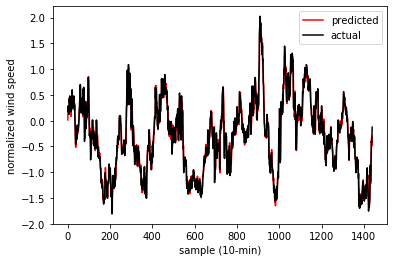

Residual mean and stdev:  2.590520390792032e-17 0.1461786883350794


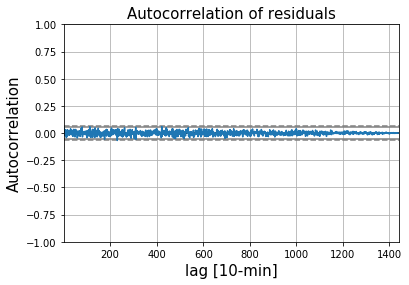

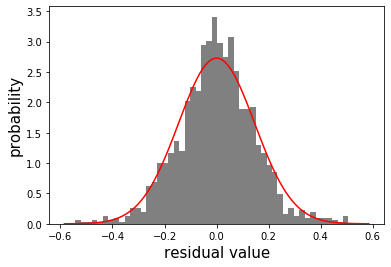

In [4]:
# Generate prediction model
model, res, stdevRes = createPredictionModel(trainX, trainY, method='LR')
print('Residual mean: ', numpy.mean(res), 'Residual stdev: ', stdevRes)

# Plot diagnostics on residuals
if plotResidualDiagnostics:
    plot_fit(model.predict(trainX), trainY)
    plot_res_autocor(res)
    plot_res_hist(res)
else:
    print('No residual diagnostics are plotted!')

# Generate scenarios
for j in range(numScenarios):
    arrayActual, arrayPredicted = forecastForward(testSet, testX, model, scaler, periodsFuture, stdevRes, mask=mask, testY=testY, positivityRequirement=True)

    arrayActual, arrayPredicted = scaler.inverse_transform(arrayActual), scaler.inverse_transform(arrayPredicted)
    scenarios[j, :] = arrayPredicted

### Visualizations and reporting

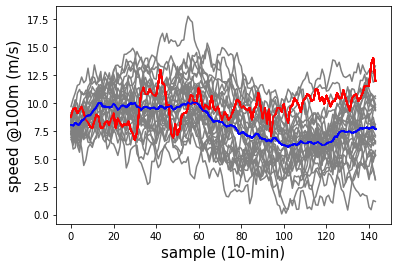

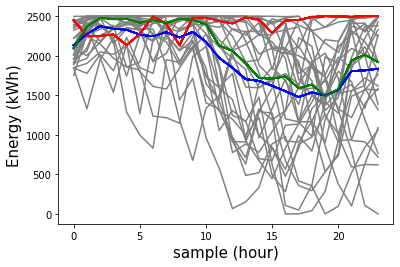

Directory already exists! Refreshing its contents:  data/2020-02-09


In [5]:
plot_windSpeedScenarios(scenarios, arrayActual)
scenariosPower = powerG126(scenarios)
actualPower = powerG126(arrayActual.reshape(1,-1))
plot_windPowerScenarios(scenariosPower, actualPower)

outputDir = createDataDirectory(outputDataDir, outputDataDir1)
scenariosPowerDf = pandas.DataFrame(data=(scenariosPower*(windfarmRatedPower/turbineRatedPower))/1000, index=['s'+str(s) for s in range(1, numScenarios+1)], columns=['t'+str(t) for t in range(1, 25)])
scenariosPowerDf.to_csv(outputDir+outputFilename)
generateScenarioTree(outputDataDir, outputDataDir1)

## Stochastic programming model 


## Display and save results
